# Week 5 Assignment using cycleGAN

# Introduction

Admittedly, I am not super familiar and this is the first time I'm using cycleGan. My work here follows closely from the tensorflow tutorial on [cycleGan](https://www.tensorflow.org/tutorials/generative/cyclegan). Our first step is to do some EDA, inspect some of the keys and see what we are working with!

In [1]:
!git clone https://github.com/tensorflow/examples.git

fatal: destination path 'examples' already exists and is not an empty directory.


In [27]:
import tensorflow as tf
import os
import time
import matplotlib.pyplot as plt
from examples.tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output
from tensorflow.keras import layers
from PIL import Image
import numpy as np

AUTOTUNE = tf.data.AUTOTUNE

So we are given the tfrecord files for Monet as explained in the kaggle competition rules, sure we can use the jpeg files but it is worth learning about the tfrecord method to avoid the i/o limits imposed by google colab, I used a similar approach in week 3 with the 220k images given. In this step, we look at the first 2 records and identify that the key we are looking at is "image" which will be used for our parsing function.

In [3]:
trial = tf.data.TFRecordDataset("/content/drive/MyDrive/5511 Introduction to Deep Learning/Week 5/monet_tfrec/monet00-60.tfrec")

for i in trial.take(2):
    example = tf.train.Example()
    example.ParseFromString(i.numpy())
    print(example)

features {
  feature {
    key: "target"
    value {
      bytes_list {
        value: "monet"
      }
    }
  }
  feature {
    key: "image"
    value {
      bytes_list {
        value: "\377\330\377\340\000\020JFIF\000\001\001\001\001,\001,\000\000\377\333\000C\000\002\001\001\001\001\001\002\001\001\001\002\002\002\002\002\004\003\002\002\002\002\005\004\004\003\004\006\005\006\006\006\005\006\006\006\007\t\010\006\007\t\007\006\006\010\013\010\t\n\n\n\n\n\006\010\013\014\013\n\014\t\n\n\n\377\333\000C\001\002\002\002\002\002\002\005\003\003\005\n\007\006\007\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\377\300\000\021\010\001\000\001\000\003\001\021\000\002\021\001\003\021\001\377\304\000\036\000\000\002\002\003\001\001\001\001\000\000\000\000\000\000\000\000\006\007\004\005\003\010\t\002\000\n\001\377\304\000K\020\000\002\001\002\004\003\005\005\004\t\003\001\007\001\t\000\003\004\005\006\023\000\002\007#\0243C\010\022\025Sc\

In [4]:
filenames = [
    '/content/drive/MyDrive/5511 Introduction to Deep Learning/Week 5/monet_tfrec/monet00-60.tfrec',
    '/content/drive/MyDrive/5511 Introduction to Deep Learning/Week 5/monet_tfrec/monet04-60.tfrec',
    '/content/drive/MyDrive/5511 Introduction to Deep Learning/Week 5/monet_tfrec/monet08-60.tfrec',
    '/content/drive/MyDrive/5511 Introduction to Deep Learning/Week 5/monet_tfrec/monet12-60.tfrec',
    '/content/drive/MyDrive/5511 Introduction to Deep Learning/Week 5/monet_tfrec/monet16-60.tfrec',
]


def _parse_function(proto):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string)
    }

    parsed_features = tf.io.parse_single_example(proto, feature_description)
    image = tf.image.decode_jpeg(parsed_features['image'], channels=3)

    return image

dataset = tf.data.TFRecordDataset(filenames)
dataset = dataset.shuffle(buffer_size=300)
dataset = dataset.map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE)

Over here, we look at the first image from the Monet dataset, to also note that the image's initial dimension is [256, 256, 3].

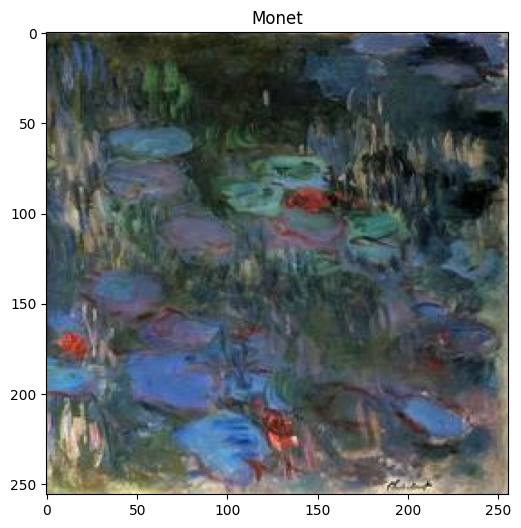

Image Dimensions: (256, 256, 3)


In [5]:
image_tensor = next(iter(dataset))
image_np = image_tensor.numpy()

plt.figure(figsize=(6, 6))
plt.imshow(image_np)
plt.title("Monet")
plt.show()

print("Image Dimensions:", image_np.shape)

We will now repeat some of the above procedures to the photo dataset; NOT MONET

In [6]:
directory_path = '/content/drive/MyDrive/5511 Introduction to Deep Learning/Week 5/photo_tfrec'

photo_filenames = []
for root, dirs, files in os.walk(directory_path):
    for file in files:
        full_path = os.path.join(root, file)
        photo_filenames.append(full_path)

NotMonet = tf.data.TFRecordDataset(photo_filenames)
NotMonet = NotMonet.map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE)

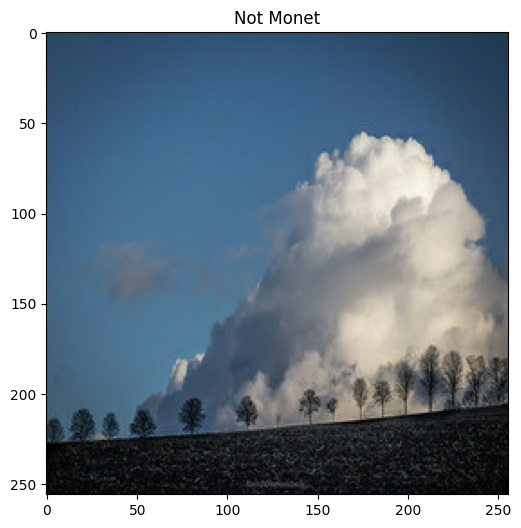

Image Dimensions: (256, 256, 3)


In [7]:
image_tensor = next(iter(NotMonet))
image_np = image_tensor.numpy()

plt.figure(figsize=(6, 6))
plt.imshow(image_np)
plt.title("Not Monet")
plt.show()

print("Image Dimensions:", image_np.shape)

# Processing of data

In [8]:
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [9]:
BATCH_SIZE = 1
train_count = 300

train_dataset = (dataset
                 .take(train_count)
                 .map(normalize, num_parallel_calls=AUTOTUNE)
                 .batch(BATCH_SIZE))

NotMonet_dataset = (NotMonet
                    .take(train_count)
                    .map(normalize, num_parallel_calls=AUTOTUNE)
                    .batch(BATCH_SIZE))

# Training

For the first portion, we will follow the tutorial from cycleGan tensorflow strictly, then we will explore using different layers/neurons to customize our own generator/discriminators

In [10]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

In [11]:
LAMBDA = 10
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)
  generated_loss = loss_obj(tf.zeros_like(generated), generated)
  total_disc_loss = real_loss + generated_loss
  return total_disc_loss * 0.5

def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [12]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [13]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [14]:
checkpoint_path = "/content/drive/MyDrive/5511 Introduction to Deep Learning/Week 5/checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [15]:
EPOCHS = 50

In [16]:
def generate_images(model, test_input):
  prediction = model(test_input)
  plt.figure(figsize=(12, 12))
  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']
  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [17]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss,
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss,
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss,
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss,
                                            discriminator_y.trainable_variables)

  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients,
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients,
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

In [18]:
sample_NotMonet = next(iter(NotMonet_dataset))

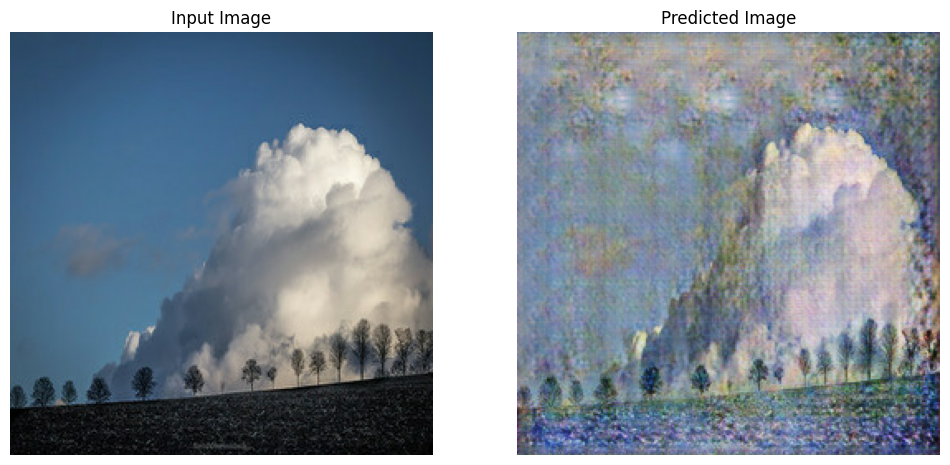

Saving checkpoint for epoch 50 at /content/drive/MyDrive/5511 Introduction to Deep Learning/Week 5/checkpoints/train/ckpt-13
Time taken for epoch 50 is 28.399248838424683 sec



In [19]:
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((NotMonet_dataset, train_dataset)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n += 1

  clear_output(wait=True)
  generate_images(generator_g, sample_NotMonet)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

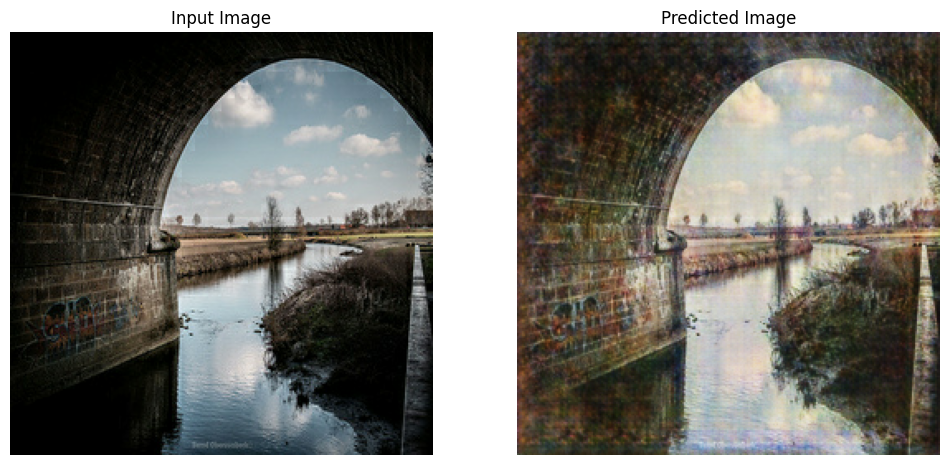

In [21]:
sample_NotMonet2 = next(iter(NotMonet_dataset.skip(1)))
generate_images(generator_g, sample_NotMonet2)

In [23]:
generator_g.save('/content/drive/MyDrive/5511 Introduction to Deep Learning/Week 5/checkpoints/generator_g.keras')

In [24]:
NotMonet_dataset = (NotMonet
                    .map(normalize, num_parallel_calls=AUTOTUNE)
                    .batch(1))

In [ ]:
output_dir = "/content/drive/MyDrive/5511 Introduction to Deep Learning/Week 5/output_images"
os.makedirs(output_dir, exist_ok=True)

for i, batch in enumerate(NotMonet_dataset):
    pred = generator_g(batch, training=False)
    pred = pred[0].numpy()
    pred = (pred + 1) / 2.0
    pred = (pred * 255).astype(np.uint8)
    filename = os.path.join(output_dir, f"pred_{i:04d}.png")
    Image.fromarray(pred).save(filename)
    print(f"Saved {filename}")

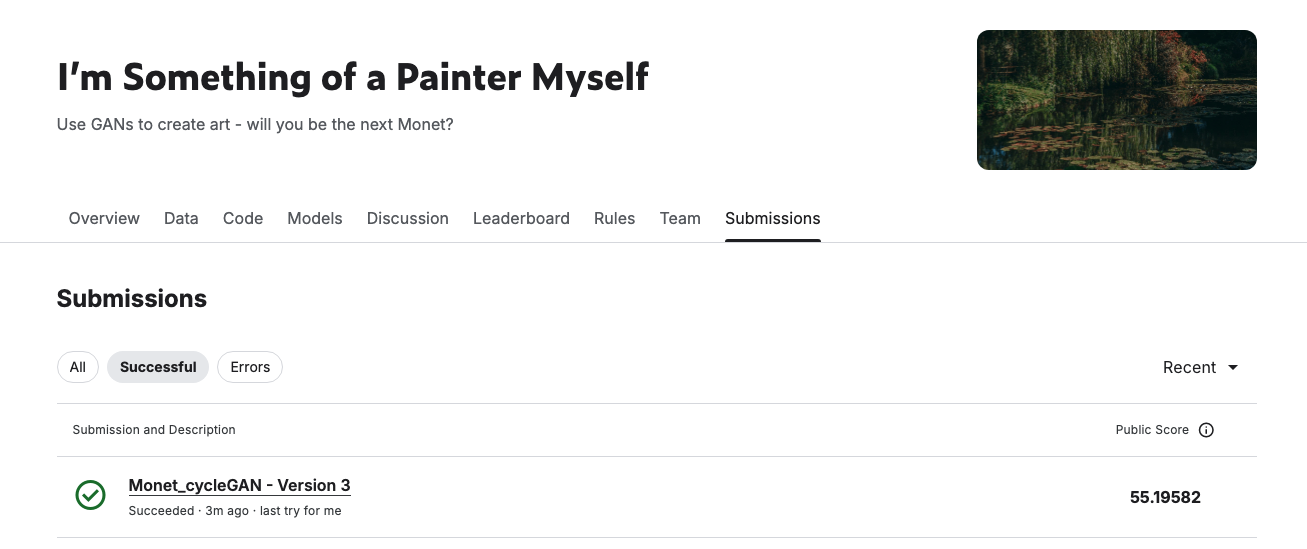

What can be done further includes making our own generator/discriminator. I really wanted to explore writing my own generator but ran into numerous issues regarding pertinent to inserting a customized generator into the above architecture. For the final part of this assignment I will try to just optimize some of the hyperparameters above and see whether we can get a better score! I will adjust the learning rate and the loss fx from binary cross entropy to lsgan.

In [39]:
OUTPUT_CHANNELS = 3

generator_a = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_b = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_c = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_d = pix2pix.discriminator(norm_type='instancenorm', target=False)

In [40]:
generator_lr = 1e-4
discriminator_lr = 5e-5

generator_a_optimizer = tf.keras.optimizers.Adam(generator_lr, beta_1=0.5)
generator_b_optimizer = tf.keras.optimizers.Adam(generator_lr, beta_1=0.5)
discriminator_c_optimizer = tf.keras.optimizers.Adam(discriminator_lr, beta_1=0.5)
discriminator_d_optimizer = tf.keras.optimizers.Adam(discriminator_lr, beta_1=0.5)

In [41]:
def generator_loss(generated):
    return tf.reduce_mean(tf.square(generated - 1.0))

def discriminator_loss(real, generated):
    real_loss = tf.reduce_mean(tf.square(real - 1.0))
    generated_loss = tf.reduce_mean(tf.square(generated))
    return 0.5 * (real_loss + generated_loss)

In [42]:
@tf.function
def train_step(real_x, real_y):

    with tf.GradientTape(persistent=True) as tape:
        fake_y = generator_a(real_x, training=True)
        cycled_x = generator_b(fake_y, training=True)
        fake_x = generator_b(real_y, training=True)
        cycled_y = generator_a(fake_x, training=True)

        same_x = generator_b(real_x, training=True)
        same_y = generator_a(real_y, training=True)

        disc_real_c = discriminator_c(real_x, training=True)
        disc_real_d = discriminator_d(real_y, training=True)

        disc_fake_c = discriminator_c(fake_x, training=True)
        disc_fake_d = discriminator_d(fake_y, training=True)

        gen_a_loss = generator_loss(disc_fake_d)
        gen_b_loss = generator_loss(disc_fake_c)

        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

        total_gen_a_loss = gen_a_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_b_loss = gen_b_loss + total_cycle_loss + identity_loss(real_x, same_x)

        disc_c_loss = discriminator_loss(disc_real_c, disc_fake_c)
        disc_d_loss = discriminator_loss(disc_real_d, disc_fake_d)

    generator_a_gradients = tape.gradient(total_gen_a_loss, generator_a.trainable_variables)
    generator_b_gradients = tape.gradient(total_gen_b_loss, generator_b.trainable_variables)
    discriminator_c_gradients = tape.gradient(disc_c_loss, discriminator_c.trainable_variables)
    discriminator_d_gradients = tape.gradient(disc_d_loss, discriminator_d.trainable_variables)

    generator_a_optimizer.apply_gradients(zip(generator_a_gradients, generator_a.trainable_variables))
    generator_b_optimizer.apply_gradients(zip(generator_b_gradients, generator_b.trainable_variables))
    discriminator_c_optimizer.apply_gradients(zip(discriminator_c_gradients, discriminator_c.trainable_variables))
    discriminator_d_optimizer.apply_gradients(zip(discriminator_d_gradients, discriminator_d.trainable_variables))


In [43]:
sample_NotMonet = next(iter(NotMonet_dataset))

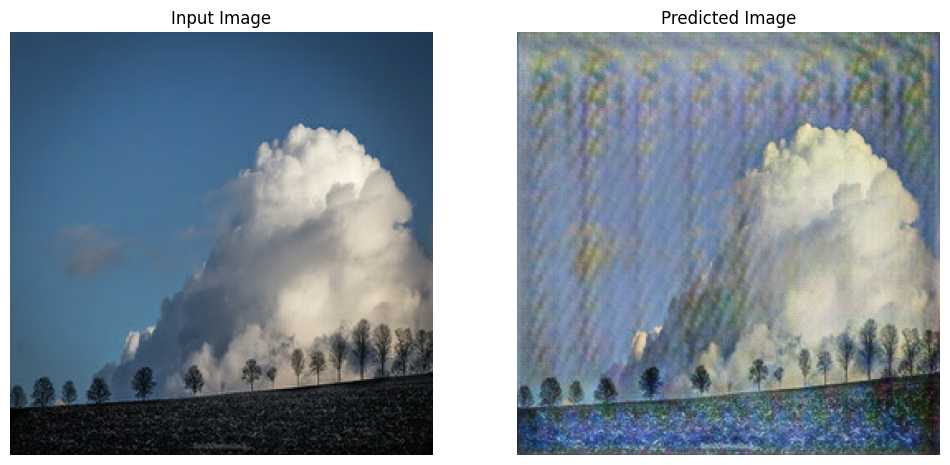

In [44]:
for epoch in range(EPOCHS):
    start = time.time()

    n = 0
    for image_x, image_y in tf.data.Dataset.zip((NotMonet_dataset, train_dataset)):
        train_step(image_x, image_y)
        if n % 10 == 0:
            print('.', end='')
        n += 1

    clear_output(wait=True)
    generate_images(generator_a, sample_NotMonet)


In [45]:
generator_a.save('/content/drive/MyDrive/5511 Introduction to Deep Learning/Week 5/checkpoints/generator_a.keras')

In [ ]:
output_dir = "/content/drive/MyDrive/5511 Introduction to Deep Learning/Week 5/output_imagesv2"
os.makedirs(output_dir, exist_ok=True)

for i, batch in enumerate(NotMonet_dataset):
    pred = generator_a(batch, training=False)
    pred = pred[0].numpy()
    pred = (pred + 1) / 2.0
    pred = (pred * 255).astype(np.uint8)
    filename = os.path.join(output_dir, f"pred_{i:04d}.png")
    Image.fromarray(pred).save(filename)
    print(f"Saved {filename}")

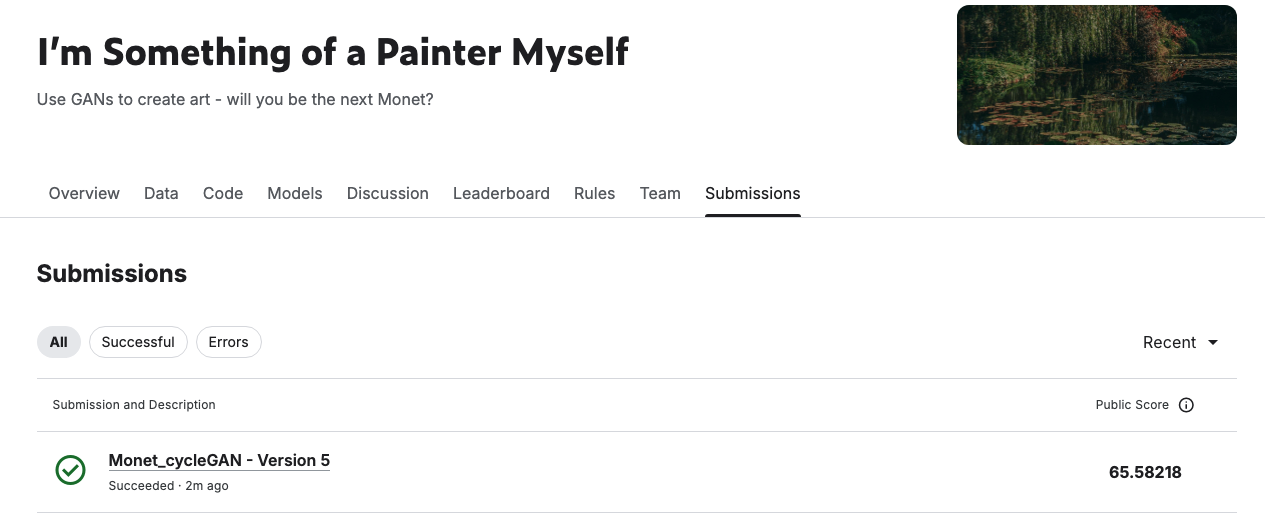

Amending the learning rate & the loss function led to a worsening of the photos. This could be seen visually, by inspecting the different photos output, as well as our more quantitative score from kaggle. More work has to be done on this aspect to improve the score further.

Sources:
1. https://www.tensorflow.org/tutorials/generative/cyclegan
2. googlecolab AI autocomplete

End~